# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2020-05-24 21:52:19--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  73.4MB/s    in 2.4s    

2020-05-24 21:52:21 (73.4 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2020-05-24 21:52:21--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M   111MB/s    in 0.6s    

2020-05-24 21:52:22 (111 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2020-05-24 21:52:22--
Total wall clock time: 3.0s
Downloaded: 2 files, 235M in

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [0]:
# First, lets load the dataset
data_train = dset.SVHN('./', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]
print("train_indices: ", train_indices)
print("val_indices: ", val_indices)

print("train_indices len: ", len(train_indices))
print("val_indices len: ", len(val_indices))
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
print("train_sampler: ", train_sampler)
print("val_sampler: ", val_sampler)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
print("train_loader: ", train_loader)
print("val_loader: ", val_loader)

train_indices:  [58673, 8135, 4613, 16694, 64673, 17332, 12122, 46931, 68811, 25192, 52931, 55319, 44859, 53043, 70818, 28799, 68707, 70872, 35509, 36070, 26384, 22030, 28966, 2110, 63354, 12083, 47960, 69971, 1008, 48973, 32062, 61810, 18604, 44317, 8605, 5368, 47586, 42702, 25961, 54716, 25194, 66885, 2695, 55952, 28031, 9536, 8616, 28990, 5857, 34368, 8554, 28911, 63656, 62005, 67995, 65605, 34542, 46210, 4631, 31151, 9854, 1697, 57427, 3240, 9445, 44678, 43525, 9598, 5084, 43223, 22852, 1491, 58518, 40079, 13419, 50837, 69663, 19353, 28354, 1999, 68841, 53097, 30685, 1728, 18211, 71656, 70234, 7318, 16665, 24165, 42453, 31436, 47735, 56668, 48003, 32417, 1656, 24800, 57169, 56531, 19791, 60238, 95, 11691, 35767, 5324, 9178, 9747, 60456, 21747, 34158, 30614, 17817, 29200, 14723, 57111, 32397, 18403, 53714, 9277, 71959, 46542, 14966, 12667, 37163, 57825, 30805, 25544, 8057, 60868, 18499, 68597, 12461, 25265, 52730, 30984, 48520, 4277, 5695, 19418, 55390, 10417, 8977, 16806, 33203, 51

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [0]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
print("SVHN data sample label: ", label)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])
SVHN data sample label:  1


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [0]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
print("loss:", loss)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

loss: CrossEntropyLoss()


## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [0]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        if scheduler != None:
            scheduler.step()

        print("Epoch: %i lr: %f; Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, get_lr(optimizer), ave_loss, train_accuracy, val_accuracy))
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct_samples = 0
    total_samples = 0 
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]            

    val_accuracy = float(correct_samples) / total_samples
    return val_accuracy

In [0]:

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)

Epoch: 0 lr: 0.010000; Average loss: 1.832724, Train accuracy: 0.406528, Val accuracy: 0.531227
Epoch: 1 lr: 0.010000; Average loss: 1.473269, Train accuracy: 0.564874, Val accuracy: 0.584465
Epoch: 2 lr: 0.010000; Average loss: 1.394475, Train accuracy: 0.605331, Val accuracy: 0.617091
Epoch: 3 lr: 0.010000; Average loss: 1.363072, Train accuracy: 0.623076, Val accuracy: 0.635793
Epoch: 4 lr: 0.010000; Average loss: 1.344841, Train accuracy: 0.633382, Val accuracy: 0.643437
Epoch: 5 lr: 0.010000; Average loss: 1.335696, Train accuracy: 0.638911, Val accuracy: 0.636748
Epoch: 6 lr: 0.010000; Average loss: 1.329625, Train accuracy: 0.642067, Val accuracy: 0.650877
Epoch: 7 lr: 0.010000; Average loss: 1.325275, Train accuracy: 0.645036, Val accuracy: 0.655996
Epoch: 8 lr: 0.010000; Average loss: 1.320410, Train accuracy: 0.649712, Val accuracy: 0.649922
Epoch: 9 lr: 0.010000; Average loss: 1.319760, Train accuracy: 0.648944, Val accuracy: 0.651969


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [0]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)

Epoch: 0 lr: 0.010000; Average loss: 2.171043, Train accuracy: 0.207675, Val accuracy: 0.243806
Epoch: 1 lr: 0.010000; Average loss: 1.973426, Train accuracy: 0.302170, Val accuracy: 0.352672
Epoch: 2 lr: 0.010000; Average loss: 1.776940, Train accuracy: 0.387281, Val accuracy: 0.415330
Epoch: 3 lr: 0.010000; Average loss: 1.701459, Train accuracy: 0.419684, Val accuracy: 0.422633
Epoch: 4 lr: 0.010000; Average loss: 1.679401, Train accuracy: 0.431236, Val accuracy: 0.437581
Epoch: 5 lr: 0.010000; Average loss: 1.666675, Train accuracy: 0.440620, Val accuracy: 0.447205
Epoch: 6 lr: 0.010000; Average loss: 1.658512, Train accuracy: 0.445791, Val accuracy: 0.458604
Epoch: 7 lr: 0.010000; Average loss: 1.651062, Train accuracy: 0.450329, Val accuracy: 0.451300
Epoch: 8 lr: 0.010000; Average loss: 1.646834, Train accuracy: 0.451728, Val accuracy: 0.458194
Epoch: 9 lr: 0.010000; Average loss: 1.645164, Train accuracy: 0.453708, Val accuracy: 0.447546


Добавьте слой с Batch Normalization

In [0]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)

Epoch: 0 lr: 0.001000; Average loss: 2.033541, Train accuracy: 0.334351, Val accuracy: 0.459354
Epoch: 1 lr: 0.001000; Average loss: 1.728312, Train accuracy: 0.484353, Val accuracy: 0.523514
Epoch: 2 lr: 0.001000; Average loss: 1.596426, Train accuracy: 0.538597, Val accuracy: 0.564535
Epoch: 3 lr: 0.001000; Average loss: 1.518797, Train accuracy: 0.573337, Val accuracy: 0.592929
Epoch: 4 lr: 0.001000; Average loss: 1.468138, Train accuracy: 0.600297, Val accuracy: 0.623507
Epoch: 5 lr: 0.001000; Average loss: 1.435088, Train accuracy: 0.618793, Val accuracy: 0.647191
Epoch: 6 lr: 0.001000; Average loss: 1.413065, Train accuracy: 0.631062, Val accuracy: 0.637977
Epoch: 7 lr: 0.001000; Average loss: 1.395945, Train accuracy: 0.641675, Val accuracy: 0.650126
Epoch: 8 lr: 0.001000; Average loss: 1.380622, Train accuracy: 0.649746, Val accuracy: 0.677565
Epoch: 9 lr: 0.001000; Average loss: 1.371556, Train accuracy: 0.661451, Val accuracy: 0.690260


Добавьте уменьшение скорости обучения по ходу тренировки.

In [0]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10, scheduler)

Epoch: 0 lr: 0.001000; Average loss: 2.078395, Train accuracy: 0.301744, Val accuracy: 0.426592
Epoch: 1 lr: 0.000500; Average loss: 1.767406, Train accuracy: 0.473194, Val accuracy: 0.521466
Epoch: 2 lr: 0.000500; Average loss: 1.648812, Train accuracy: 0.533222, Val accuracy: 0.564125
Epoch: 3 lr: 0.000250; Average loss: 1.592849, Train accuracy: 0.561359, Val accuracy: 0.591427
Epoch: 4 lr: 0.000250; Average loss: 1.553223, Train accuracy: 0.579992, Val accuracy: 0.602826
Epoch: 5 lr: 0.000125; Average loss: 1.531682, Train accuracy: 0.590213, Val accuracy: 0.614634
Epoch: 6 lr: 0.000125; Average loss: 1.514408, Train accuracy: 0.597089, Val accuracy: 0.620094
Epoch: 7 lr: 0.000063; Average loss: 1.506933, Train accuracy: 0.599461, Val accuracy: 0.623234
Epoch: 8 lr: 0.000063; Average loss: 1.496958, Train accuracy: 0.603675, Val accuracy: 0.627056
Epoch: 9 lr: 0.000031; Average loss: 1.493050, Train accuracy: 0.606047, Val accuracy: 0.624940


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [0]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    ground_truth = []
    predictions=[]
    model.eval() # Evaluation mode    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    #print(indices)  
    #print(len(indices))
    smpl = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=smpl)
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        #print("y", y)
        #print(y.size())
        #break
        #print("pred:", prediction)
        #break
        _, indices = torch.max(prediction, 1)
        #print("indices: ", indices)
        #break
        for i in range(len(prediction)):
            predictions.append(indices[i])
            ground_truth.append(y[i])

    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
#print(len(predictions[0]))
#print(len(predictions))
#print(len(gt))
#print(gt)
#print(gt[0])
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))
print("ok")

ok


## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

![image.png](attachment:image.png)

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

ok


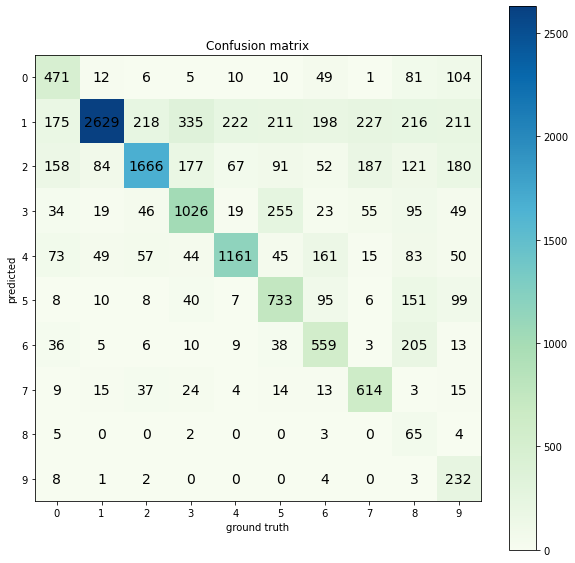

In [0]:
def visualize_confusion_matrix(confusion_matrix, title):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title(title)
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    for i in range(len(predictions)):
        p=predictions[i]
        y=ground_truth[i]
        confusion_matrix[p][y]+=1

    # TODO: Implement filling the prediction matrix
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix, "Confusion matrix")
print("ok")

Epoch: 0 lr: 0.001000; Average loss: 2.091046, Train accuracy: 0.288162, Val accuracy: 0.411235
Epoch: 1 lr: 0.000500; Average loss: 1.810819, Train accuracy: 0.465652, Val accuracy: 0.517234
Epoch: 2 lr: 0.000500; Average loss: 1.688977, Train accuracy: 0.526806, Val accuracy: 0.547266
Epoch: 3 lr: 0.000250; Average loss: 1.630603, Train accuracy: 0.552674, Val accuracy: 0.573135
Epoch: 4 lr: 0.000250; Average loss: 1.589338, Train accuracy: 0.570727, Val accuracy: 0.584192
Epoch: 5 lr: 0.000125; Average loss: 1.564781, Train accuracy: 0.582312, Val accuracy: 0.596751
Epoch: 6 lr: 0.000125; Average loss: 1.548599, Train accuracy: 0.589001, Val accuracy: 0.604873
Epoch: 7 lr: 0.000063; Average loss: 1.538213, Train accuracy: 0.590946, Val accuracy: 0.611767
Epoch: 8 lr: 0.000063; Average loss: 1.528497, Train accuracy: 0.596645, Val accuracy: 0.606785
Epoch: 9 lr: 0.000031; Average loss: 1.523904, Train accuracy: 0.598625, Val accuracy: 0.608150
Epoch: 0 lr: 0.000031; Average loss: 1.5

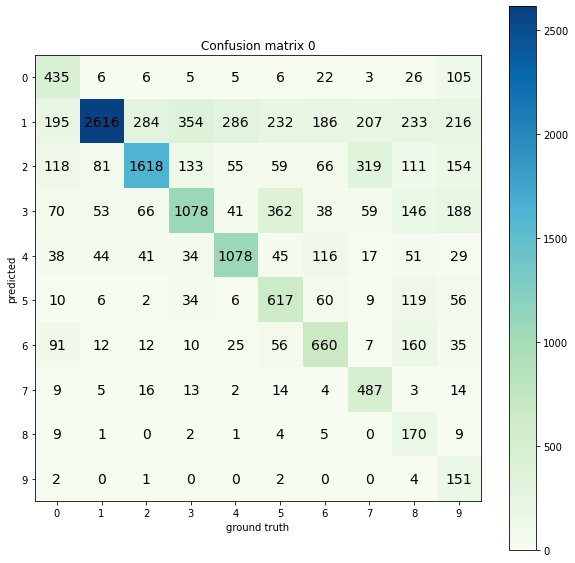

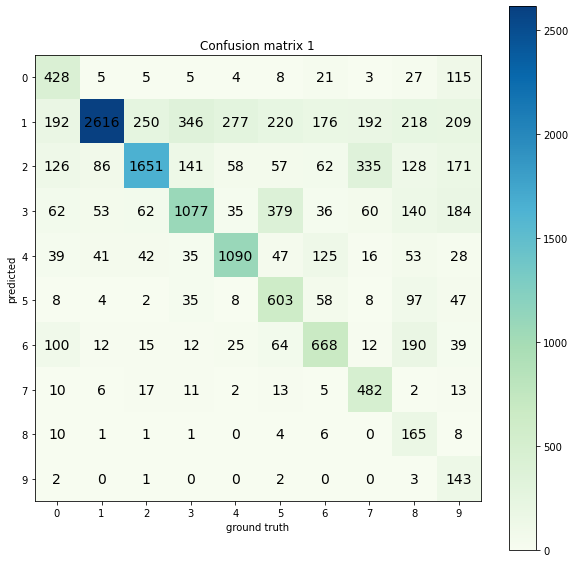

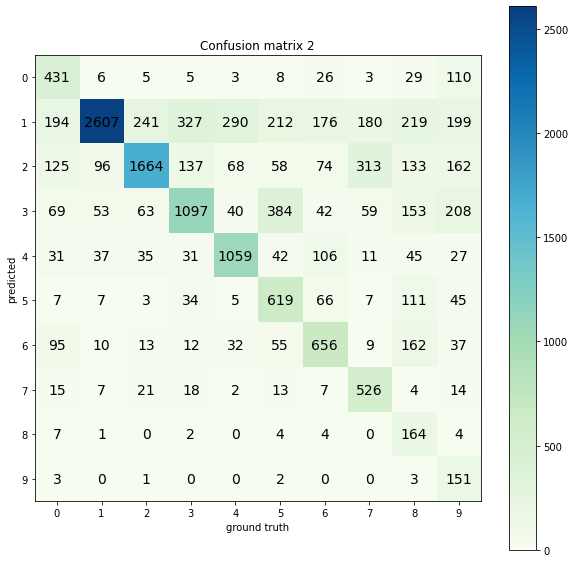

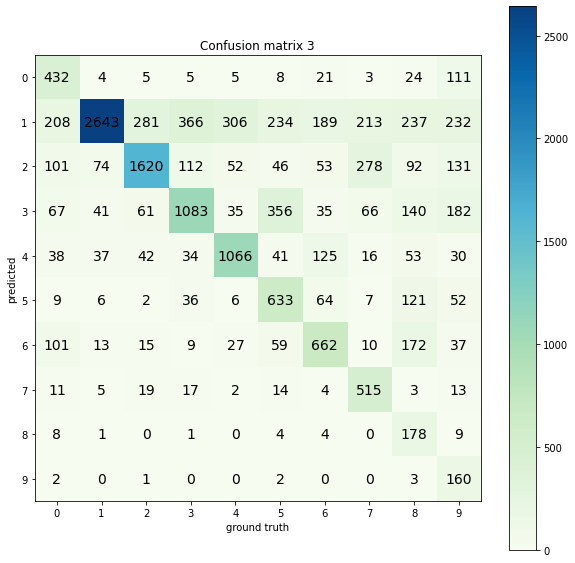

In [0]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
epochs=4
for i in range(epochs):
    loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10, scheduler)

    predictions, gt = evaluate_model(nn_model, data_train, val_indices)
    confusion_matrix = build_confusion_matrix(predictions, gt)
    visualize_confusion_matrix(confusion_matrix, f"Confusion matrix {i}")
        


Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

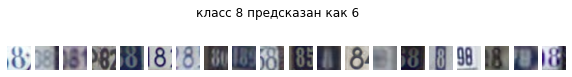

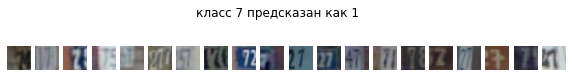

In [0]:
data_train_images = dset.SVHN('./', split='train')

def visualize_images(indices, data, title, max_num):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data, max_num):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    indices=[]
    for i in range(len(predictions)):
        p=predictions[i]
        if p != predicted_class: continue
        y=ground_truth[i]
        if y != gt_class: continue
        indices.append(val_indices[i])

    visualize_images(indices, data, f'класс {gt_class} предсказан как {predicted_class}', max_num)

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images, 20)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images, 20)

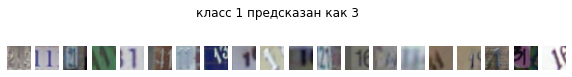

In [0]:

visualize_predicted_actual(3, 1, predictions, gt, np.array(val_indices), data_train_images, 20)

In [0]:
print(val_indices)
c=0
for i in val_indices:
  print(i)
  c+=1
  if c>10: break

[21116, 62066, 11150, 52583, 1830, 38261, 26727, 5127, 27493, 64120, 62883, 25516, 50111, 21542, 56682, 20363, 55300, 41852, 66421, 10235, 9787, 21175, 39932, 59714, 46615, 45014, 33856, 70512, 15597, 24191, 59187, 48083, 61981, 44913, 35364, 20186, 35233, 38135, 37692, 21638, 68085, 1535, 49402, 29806, 24213, 64915, 11990, 12435, 59651, 64903, 13345, 33419, 72489, 68865, 399, 17559, 20859, 33284, 41506, 64324, 24362, 25404, 41974, 39245, 12419, 8693, 68241, 13945, 43561, 5166, 9750, 44274, 424, 61975, 51375, 4888, 62681, 64438, 16153, 72155, 39876, 56524, 37226, 25145, 20021, 70027, 21188, 35561, 10180, 30836, 62290, 21990, 21226, 72640, 71151, 60455, 8760, 14973, 29104, 57235, 52401, 22794, 12679, 47323, 42777, 60178, 54453, 32001, 22131, 41419, 9790, 14096, 40166, 28428, 38928, 13238, 31342, 15497, 36953, 32969, 53076, 24897, 62969, 70938, 14720, 42682, 1835, 20814, 47715, 37258, 47063, 61140, 23970, 69661, 28559, 52524, 46700, 42841, 41373, 49748, 63717, 54894, 23824, 55577, 40549,

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [0]:
# Experiment here!

In [0]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

In [0]:
9 % 10

9